In [47]:
import pandas as pd
import numpy as np
import requests

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [48]:
df = pd.read_csv("C:\\Users\\joaov\\Documents\\Whisky Casks ETL\\gold\\casks_database.csv")
df

,url,hammer_price,sold,auction_date,title,distillery,region,strength,distillery_status,cask_type,...,regauged_date,age,bottles_at_cask_strength,hammer_price_per_bottle_at_cask_strength,hammer_price_per_litre_of_alcohol,buyer_price,buyer_price_per_bottle_at_cask_strength,buyer_price_per_litre_of_alcohol,country,auction_house
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,18500.0,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,...,2024-10-01,20.00,212.30,87.14,247.00,20812.50,98.03,277.87,Scotland,WhiskyAuctioneer
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,1000.0,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,...,2024-10-01,13.00,164.86,6.07,13.37,1125.00,6.82,15.04,England,WhiskyAuctioneer
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,1000.0,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,...,2024-10-01,9.00,247.97,4.03,8.96,1125.00,4.54,10.08,England,WhiskyAuctioneer
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,250.0,False,2024-12-02,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,...,2024-10-01,9.00,247.97,1.01,2.24,281.25,1.13,2.52,England,WhiskyAuctioneer
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,21500.0,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,...,2024-06-01,NaN,310.20,69.31,186.47,24187.50,77.97,209.78,Scotland,WhiskyAuctioneer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,https://www.whiskyhammer.com/item/185734/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.30,NaN,Hogshead,...,2024-08-01,3.69,312.14,9.61,22.04,300.00,0.96,2.20,Scotland,Whisky Hammer
564,https://www.whiskyhammer.com/item/185726/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,2024-08-01,3.69,321.57,9.33,21.29,300.00,0.93,2.13,Scotland,Whisky Hammer
565,https://www.whiskyhammer.com/item/185729/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,63.10,NaN,Hogshead,...,2024-08-01,3.69,334.00,8.98,20.33,300.00,0.90,2.03,Scotland,Whisky Hammer
566,https://www.whiskyhammer.com/item/185736/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,2024-08-01,3.69,319.00,9.40,21.46,300.00,0.94,2.15,Scotland,Whisky Hammer


# Inflation Adjustment

In [49]:
# Transforms date columns to datetime format

df['filling_date'] = pd.to_datetime(df['filling_date'], format='%Y-%m-%d')

df['auction_date'] = pd.to_datetime(df['auction_date'], format='%Y-%m-%d')
df['year'] = df['auction_date'].dt.year
df['month'] = df['auction_date'].dt.month
df['auction_date'] = df['auction_date'].dt.date.astype(str)
df

,url,hammer_price,sold,auction_date,title,distillery,region,strength,distillery_status,cask_type,...,bottles_at_cask_strength,hammer_price_per_bottle_at_cask_strength,hammer_price_per_litre_of_alcohol,buyer_price,buyer_price_per_bottle_at_cask_strength,buyer_price_per_litre_of_alcohol,country,auction_house,year,month
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,18500.0,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,...,212.30,87.14,247.00,20812.50,98.03,277.87,Scotland,WhiskyAuctioneer,2025,1
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,1000.0,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,...,164.86,6.07,13.37,1125.00,6.82,15.04,England,WhiskyAuctioneer,2025,1
2,https://whiskyauctioneer.com/lot/1124-01a/cask...,1000.0,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,...,247.97,4.03,8.96,1125.00,4.54,10.08,England,WhiskyAuctioneer,2025,1
3,https://whiskyauctioneer.com/lot/1124-01/cask-...,250.0,False,2024-12-02,Copper House 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,...,247.97,1.01,2.24,281.25,1.13,2.52,England,WhiskyAuctioneer,2024,12
4,https://whiskyauctioneer.com/lot/0824-05a/cask...,21500.0,True,2024-12-02,Bruichladdich 2002 Climens Hogshead,Bruichladdich,Islay,53.10,Operational,Hogshead,...,310.20,69.31,186.47,24187.50,77.97,209.78,Scotland,WhiskyAuctioneer,2024,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,https://www.whiskyhammer.com/item/185734/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.30,NaN,Hogshead,...,312.14,9.61,22.04,300.00,0.96,2.20,Scotland,Whisky Hammer,2024,9
564,https://www.whiskyhammer.com/item/185726/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,321.57,9.33,21.29,300.00,0.93,2.13,Scotland,Whisky Hammer,2024,9
565,https://www.whiskyhammer.com/item/185729/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,63.10,NaN,Hogshead,...,334.00,8.98,20.33,300.00,0.90,2.03,Scotland,Whisky Hammer,2024,9
566,https://www.whiskyhammer.com/item/185736/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,319.00,9.40,21.46,300.00,0.94,2.15,Scotland,Whisky Hammer,2024,9


In [50]:
most_recent_date = str(df['auction_date'].max())[:10].replace('-', '/')

list_of_dates = df['auction_date'].values
list_of_values = df['hammer_price'].values

dates_as_strings = [str(date)[:10].replace('-', '/') for date in list_of_dates]

payload = {
    'dates': dates_as_strings,
    'values': list_of_values.tolist(),
    'currency': 'GBP',
    'present_date': most_recent_date
}

headers = {
    "Content-Type": "application/json"
}

values_inflation_adjusted = requests.post('https://financial-utilities-api.onrender.com/inflation_adjustment', json=payload, headers=headers)

if values_inflation_adjusted.status_code != 200:
    values_inflation_adjusted = requests.post('https://financial-utilities-api.onrender.com/inflation_adjustment', json=payload, headers=headers)

df_inflation_adjusted_values = pd.DataFrame(values_inflation_adjusted.json())

df_inflation_adjusted_values.columns = ['date', 'original_value', 'inflation_adjusted_hammer_price', 'acumulated_inflaition_rate']

df_inflation_adjusted_values['date'] = pd.to_datetime(df_inflation_adjusted_values['date']).dt.date.astype(str)

df = (
    df
    .merge(
        df_inflation_adjusted_values[['date', 'original_value', 'inflation_adjusted_hammer_price']],
        left_on=['auction_date', 'hammer_price'],
        right_on=['date', 'original_value'],
        how='left'
    )
)

df = df.drop(columns=['date', 'original_value'])

df

,url,hammer_price,sold,auction_date,title,distillery,region,strength,distillery_status,cask_type,...,hammer_price_per_bottle_at_cask_strength,hammer_price_per_litre_of_alcohol,buyer_price,buyer_price_per_bottle_at_cask_strength,buyer_price_per_litre_of_alcohol,country,auction_house,year,month,inflation_adjusted_hammer_price
0,https://whiskyauctioneer.com/lot/1224-01/cask-...,18500.0,True,2025-01-06,Port Charlotte 2004 Fresh Bourbon Barrel,Bruichladdich,Islay,50.40,Operational,Barrel,...,87.14,247.00,20812.5,98.03,277.87,Scotland,WhiskyAuctioneer,2025,1,26644.13
1,https://whiskyauctioneer.com/lot/1124-02a/cask...,1000.0,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,...,6.07,13.37,1125.0,6.82,15.04,England,WhiskyAuctioneer,2025,1,1440.22
2,https://whiskyauctioneer.com/lot/1124-02a/cask...,1000.0,False,2025-01-06,Adnams 201Jack Daniel's Barrel,Copper House,England,64.80,Operational,Barrel,...,6.07,13.37,1125.0,6.82,15.04,England,WhiskyAuctioneer,2025,1,1440.22
3,https://whiskyauctioneer.com/lot/1124-01a/cask...,1000.0,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,...,4.03,8.96,1125.0,4.54,10.08,England,WhiskyAuctioneer,2025,1,1440.22
4,https://whiskyauctioneer.com/lot/1124-01a/cask...,1000.0,False,2025-01-06,Adnams 2015 French Oak Cask,Copper House,England,64.29,Operational,NaN,...,4.03,8.96,1125.0,4.54,10.08,England,WhiskyAuctioneer,2025,1,1440.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,https://www.whiskyhammer.com/item/185736/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,9.40,21.46,300.0,0.94,2.15,Scotland,Whisky Hammer,2024,9,4727.36
1070,https://www.whiskyhammer.com/item/185736/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,9.40,21.46,300.0,0.94,2.15,Scotland,Whisky Hammer,2024,9,4727.36
1071,https://www.whiskyhammer.com/item/185736/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,9.40,21.46,300.0,0.94,2.15,Scotland,Whisky Hammer,2024,9,4727.36
1072,https://www.whiskyhammer.com/item/185736/Other...,3000.0,True,2024-09-08,Lowland Single Malt - 2021 Ex-Sherry Hogshead ...,Undisclosed Distillery,Lowlands,62.60,NaN,Hogshead,...,9.40,21.46,300.0,0.94,2.15,Scotland,Whisky Hammer,2024,9,4727.36


In [51]:
df.sort_values('auction_date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

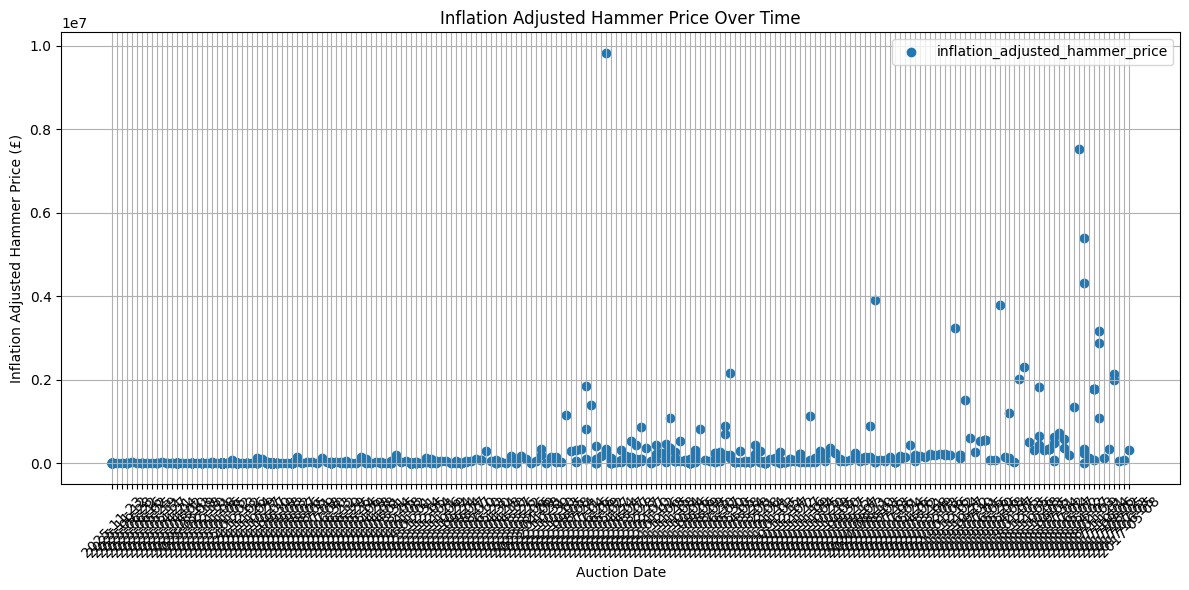

In [52]:
plt.figure(figsize=(12, 6))
plt.scatter(df['auction_date'], df['inflation_adjusted_hammer_price'], label='inflation_adjusted_hammer_price', marker='o')
plt.title('Inflation Adjusted Hammer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Inflation Adjusted Hammer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Data preparation

In [14]:
# Drops unused columns
df.drop(columns=['url','sold','title','currency','filling_date','regauged_date','auction_house','buyer_price','adjust_value','year','month','hammer_price_per_bottle_at_cask_strength','hammer_price_per_litre_of_alcohol'], inplace=True)
df

,hammer_price,auction_date,distillery,region,strength,distillery_status,cask_type,bulk_litres,rla,cask_filling,previous_spirit,age,bottles_at_cask_strength,buyer_price_per_bottle_at_cask_strength,buyer_price_per_litre_of_alcohol,country,adjusted_buyer_price
0,35000.0,2025-06-16,Springbank,Campbeltown,43.3,Operational,Hogshead,131.80,57.90,First Fill,Bourbon,25.46,188.285714,23.24,75.56,Scotland,NaN
1,1525.0,2025-06-02,Tullibardine,Highlands,69.4,Operational,Barrel,157.06,109.00,NaN,NaN,7.24,224.370000,0.68,1.40,Scotland,NaN
2,5300.0,2025-05-19,Arran,Highlands,58.6,Operational,Hogshead,226.00,134.00,First Fill,Sherry,12.21,322.857143,2.05,4.94,Scotland,NaN
3,2000.0,2025-05-11,Tullibardine,Highlands,65.0,Operational,Hogshead,200.62,130.40,NaN,Wine,5.97,286.600000,0.70,1.53,Scotland,NaN
4,22250.0,2025-04-21,Ben Nevis,Highlands,49.6,Operational,Hogshead,159.73,80.10,NaN,NaN,29.06,228.185714,12.19,34.72,Scotland,2814.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,12850.0,2018-05-07,Bruichladdich,Islay,64.1,Operational,Barrique,201.00,128.84,NaN,Wine,14.00,287.140000,50.35,112.20,Scotland,18896.49
378,45460.0,2018-04-02,Ben Nevis,Highlands,57.2,Operational,Butt,398.65,230.76,NaN,Sherry,21.00,569.500000,89.80,221.63,Scotland,67118.34
379,1500.0,2017-07-03,Ardmore,Highlands,NaN,Operational,NaN,NaN,NaN,NaN,Bourbon,7.00,NaN,NaN,NaN,Scotland,2250.26
380,2200.0,2017-06-05,Linkwood,Speyside,NaN,Operational,Hogshead,NaN,NaN,Second Fill,NaN,7.00,NaN,NaN,NaN,Scotland,3300.38


In [15]:
df.isnull().sum()

hammer_price                                 0
auction_date                                 0
distillery                                   3
region                                       1
strength                                     6
distillery_status                            1
cask_type                                   42
bulk_litres                                  8
rla                                         10
cask_filling                               190
previous_spirit                            165
age                                         94
bottles_at_cask_strength                     8
buyer_price_per_bottle_at_cask_strength      8
buyer_price_per_litre_of_alcohol            10
country                                      2
adjusted_buyer_price                         4
dtype: int64

In [ ]:
# Drop columns with too much NaN values
df.drop(columns=['cask_filling','previous_spirit'], inplace=True)
df

,hammer_price,auction_date,distillery,region,strength,distillery_status,bulk_litres,rla,age,bottles_at_cask_strength,buyer_price_per_bottle_at_cask_strength,buyer_price_per_litre_of_alcohol,country,adjusted_buyer_price
0,35000.0,2025-06-16,Springbank,Campbeltown,43.3,Operational,131.80,57.90,25.46,188.285714,23.24,75.56,Scotland,NaN
1,1525.0,2025-06-02,Tullibardine,Highlands,69.4,Operational,157.06,109.00,7.24,224.370000,0.68,1.40,Scotland,NaN
2,5300.0,2025-05-19,Arran,Highlands,58.6,Operational,226.00,134.00,12.21,322.857143,2.05,4.94,Scotland,NaN
3,2000.0,2025-05-11,Tullibardine,Highlands,65.0,Operational,200.62,130.40,5.97,286.600000,0.70,1.53,Scotland,NaN
4,22250.0,2025-04-21,Ben Nevis,Highlands,49.6,Operational,159.73,80.10,29.06,228.185714,12.19,34.72,Scotland,2814.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,12850.0,2018-05-07,Bruichladdich,Islay,64.1,Operational,201.00,128.84,14.00,287.140000,50.35,112.20,Scotland,18896.49
378,45460.0,2018-04-02,Ben Nevis,Highlands,57.2,Operational,398.65,230.76,21.00,569.500000,89.80,221.63,Scotland,67118.34
379,1500.0,2017-07-03,Ardmore,Highlands,NaN,Operational,NaN,NaN,7.00,NaN,NaN,NaN,Scotland,2250.26
380,2200.0,2017-06-05,Linkwood,Speyside,NaN,Operational,NaN,NaN,7.00,NaN,NaN,NaN,Scotland,3300.38


In [17]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

hammer_price                               0
auction_date                               0
distillery                                 0
region                                     0
strength                                   0
distillery_status                          0
bulk_litres                                0
rla                                        0
age                                        0
bottles_at_cask_strength                   0
buyer_price_per_bottle_at_cask_strength    0
buyer_price_per_litre_of_alcohol           0
country                                    0
adjusted_buyer_price                       0
dtype: int64

## Outliers filtering

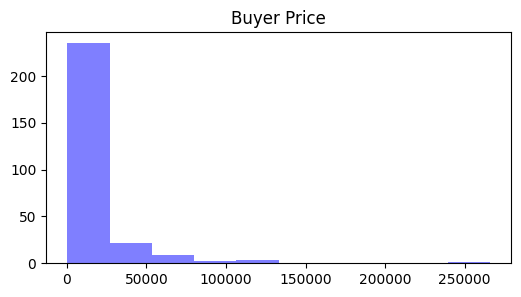

In [18]:
plt.figure(figsize=(6, 3))
plt.hist(df['adjusted_buyer_price'], color='blue', alpha=0.5)
plt.title('Buyer Price')
plt.show()

In [19]:
Q1 = df['adjusted_buyer_price'].quantile(0.25)
Q3 = df['adjusted_buyer_price'].quantile(0.75)
IQR = Q3 - Q1

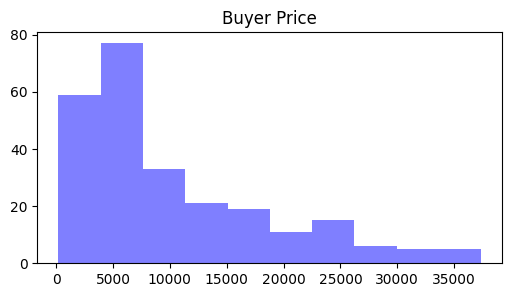

In [20]:

filtro = (df['adjusted_buyer_price'] >= (Q1 - 1.5 * IQR)) & (df['adjusted_buyer_price'] <= (Q3 + 1.5 * IQR))
df = df[filtro].reset_index(drop=True)
plt.figure(figsize=(6, 3))
plt.hist(df['adjusted_buyer_price'], color='blue', alpha=0.5)
plt.title('Buyer Price')
plt.show()

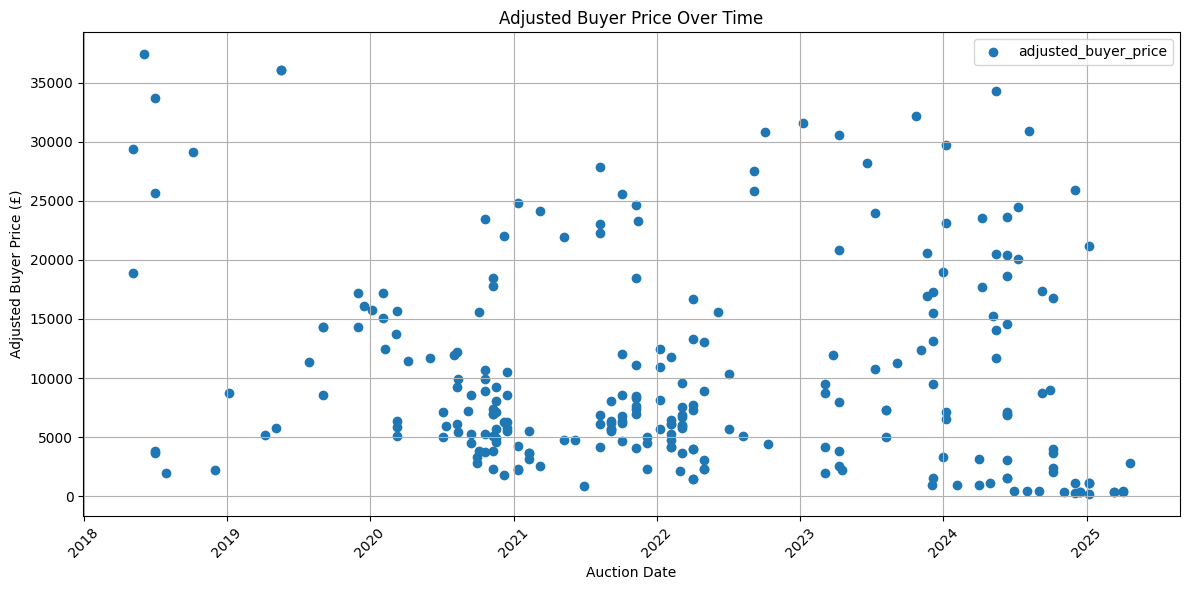

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(df['auction_date'], df['adjusted_buyer_price'], label='adjusted_buyer_price', marker='o')
plt.title('Adjusted Buyer Price Over Time')
plt.xlabel('Auction Date')
plt.ylabel('Adjusted Buyer Price (£)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
df.drop(columns=['auction_date'], inplace=True)

## Log transformation

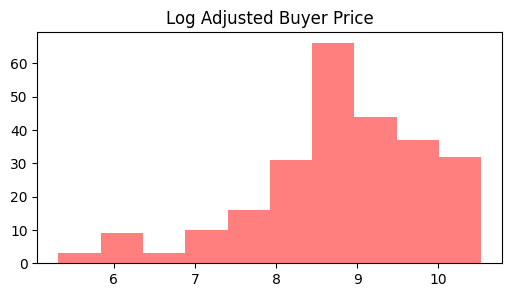

In [23]:
plt.figure(figsize=(6, 3))
plt.hist(np.log(df['adjusted_buyer_price']), color='red', alpha=0.5)
plt.title('Log Adjusted Buyer Price')
plt.show()

## Box-Cox transformation

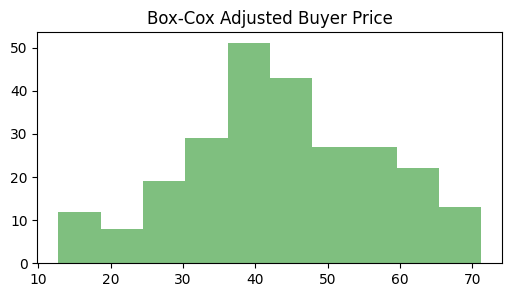

In [24]:
# Supondo que seus dados estejam em y
y_boxcox, fitted_lambda = boxcox(df['adjusted_buyer_price'])

plt.figure(figsize=(6, 3))
plt.hist(y_boxcox, color='green', alpha=0.5)
plt.title('Box-Cox Adjusted Buyer Price')
plt.show()

# Feature selection

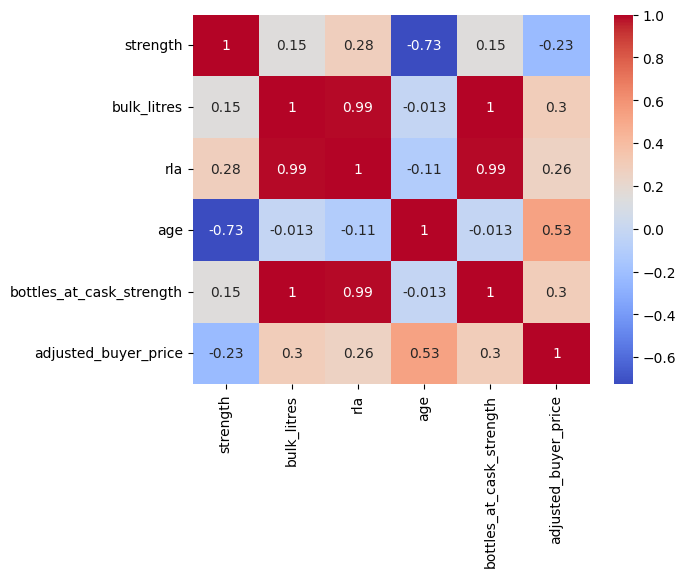

In [25]:
corr = df[['strength','bulk_litres','rla','age','bottles_at_cask_strength','adjusted_buyer_price']].corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [26]:
# Drop column with high correlation to 'Rla'
df_correlation_selection = df.drop(columns=['bulk_litres','bottles_at_cask_strength'])

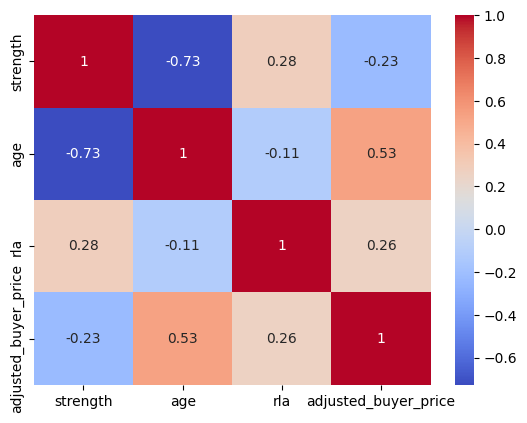

In [27]:
corr = df[['strength','age','rla','adjusted_buyer_price']].corr(method='pearson')

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## One hot encoding for categorical variables

In [28]:
df = pd.get_dummies(df, columns=['distillery','region','distillery_status','country'], drop_first=True, dtype=int)

In [29]:
df_correlation_selection = pd.get_dummies(df_correlation_selection, columns=['distillery','region','distillery_status','country'], drop_first=True, dtype=int)

# Split train and test data

In [30]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['adjusted_buyer_price'])
y = df['adjusted_buyer_price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Log transformation
y_train_log = np.log(y_train)

# Box-Cox transformation
y_train_boxcox, fitted_lambda = boxcox(y_train)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
x_train[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength']] = scaler_x_train.fit_transform(x_train[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength']])

scaler_x_test = StandardScaler()
x_test[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength']] = scaler_x_test.fit_transform(x_test[['strength', 'bulk_litres', 'rla', 'age', 'bottles_at_cask_strength']])

In [31]:
x_train_corr_sel = x_train.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])
x_test_corr_sel = x_test.drop(columns=['bulk_litres', 'bottles_at_cask_strength'])

# ML Models - No transformation

In [150]:
models_metrics = []

features = 'All features'
transformation = 'No transformation'

## Linear Regression

In [151]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [152]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3671.27


,Actual,Predicted,Error
0,6897.66,6812.417728,85.24
1,203.82,5069.997487,-4866.18
2,2553.68,1230.961021,1322.72
3,1549.54,-1077.486499,2627.03
4,5780.71,5609.065077,171.64
5,8094.70,18047.354284,-9952.65
6,8946.78,9512.453989,-565.67
7,37386.71,32725.201784,4661.51
8,327.09,306.330120,20.76
9,6091.93,6405.123268,-313.19


## Random Forest

In [153]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
217 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: -2684.79
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [154]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 2912.48


,Actual,Predicted,Error
0,6897.66,6621.262200,276.40
1,203.82,2722.629050,-2518.81
2,2553.68,3696.547400,-1142.87
3,1549.54,2687.167200,-1137.63
4,5780.71,6200.630600,-419.92
5,8094.70,9323.386906,-1228.69
6,8946.78,7609.292742,1337.49
7,37386.71,28491.181000,8895.53
8,327.09,1117.077900,-789.99
9,6091.93,6347.608700,-255.68


## SVM

In [155]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best RMSE: -5713.40
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [156]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 2809.21


,Actual,Predicted,Error
0,6897.66,6734.260432,163.40
1,203.82,2269.344470,-2065.52
2,2553.68,4011.119322,-1457.44
3,1549.54,2118.128045,-568.59
4,5780.71,6514.777552,-734.07
5,8094.70,9136.766564,-1042.07
6,8946.78,8202.498829,744.28
7,37386.71,34407.344152,2979.37
8,327.09,1857.727168,-1530.64
9,6091.93,6226.977172,-135.05


## Gradient Boosting

In [157]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: -1663.67
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10,
                          min_samples_split=10, random_state=1)


In [158]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 1213.62


,Actual,Predicted,Error
0,6897.66,6807.235679,90.42
1,203.82,1031.422229,-827.60
2,2553.68,2304.170232,249.51
3,1549.54,1861.616227,-312.08
4,5780.71,5977.025702,-196.32
5,8094.70,6324.335147,1770.36
6,8946.78,8807.016605,139.76
7,37386.71,33430.388782,3956.32
8,327.09,462.050942,-134.96
9,6091.93,6190.208833,-98.28


# ML Models - Log transformation

In [159]:
features = 'All features'
transformation =  'Log transformation'

## Linear Regression

In [160]:
model = LinearRegression()
model.fit(x_train, y_train_log)

y_pred = model.predict(x_test)

In [161]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 11680.96


,Actual,Predicted,Error
0,6897.66,6260.344714,637.32
1,203.82,9932.040984,-9728.22
2,2553.68,2803.974098,-250.29
3,1549.54,2277.202862,-727.66
4,5780.71,6136.423116,-355.71
5,8094.70,23502.071138,-15407.37
6,8946.78,6694.298727,2252.48
7,37386.71,49509.502744,-12122.79
8,327.09,1144.926382,-817.84
9,6091.93,6408.281733,-316.35


## Random Forest

In [162]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
187 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: -0.26
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [163]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3472.33


,Actual,Predicted,Error
0,6897.66,6576.807670,320.85
1,203.82,1520.524123,-1316.70
2,2553.68,3191.301378,-637.62
3,1549.54,2507.125652,-957.59
4,5780.71,6241.027095,-460.32
5,8094.70,6232.025482,1862.67
6,8946.78,6672.653776,2274.13
7,37386.71,24458.431851,12928.28
8,327.09,603.072061,-275.98
9,6091.93,6370.106637,-278.18


## SVM

In [164]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

KeyboardInterrupt: 

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3709.43


,Actual,Predicted,Error
0,36038.23,37161.704533,-1123.47
1,1970.83,1681.362548,289.47
2,4024.52,4251.558222,-227.04
3,6357.45,6072.973616,284.48
4,30871.97,17639.175404,13232.79
5,11714.85,15832.986928,-4118.14
6,18676.26,16021.471731,2654.79
7,11940.82,4533.097386,7407.72
8,8529.27,4352.725043,4176.54
9,12014.80,7892.361822,4122.44


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: -0.45
Best estimator: GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=10,
                          n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4985.74


,Actual,Predicted,Error
0,36038.23,17723.269388,18314.96
1,1970.83,1862.986600,107.84
2,4024.52,9930.264286,-5905.74
3,6357.45,5074.061722,1283.39
4,30871.97,17974.998783,12896.97
5,11714.85,11200.739163,514.11
6,18676.26,23205.759753,-4529.50
7,11940.82,7271.963244,4668.86
8,8529.27,7643.066056,886.20
9,12014.80,8772.705019,3242.09


# ML Models - Box-Cox transformation

In [ ]:
features = 'All features'
transformation =  'Box-Cox transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train_boxcox)

y_pred = model.predict(x_test)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4399.88


,Actual,Predicted,Error
0,36038.23,34650.874337,1387.36
1,1970.83,2249.724827,-278.89
2,4024.52,1176.116757,2848.40
3,6357.45,4068.521523,2288.93
4,30871.97,26332.748352,4539.22
5,11714.85,12363.234004,-648.38
6,18676.26,25859.626478,-7183.37
7,11940.82,5165.119075,6775.70
8,8529.27,7137.910294,1391.36
9,12014.80,7445.994093,4568.81


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
184 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -4.54
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4275.01


,Actual,Predicted,Error
0,36038.23,18435.517011,17602.71
1,1970.83,2358.213497,-387.38
2,4024.52,10890.043507,-6865.52
3,6357.45,5258.897597,1098.55
4,30871.97,18425.692027,12446.28
5,11714.85,13440.991197,-1726.14
6,18676.26,13013.943442,5662.32
7,11940.82,6302.174865,5638.65
8,8529.27,5212.113805,3317.16
9,12014.80,7646.989931,4367.81


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Best RMSE: -4.21
Best estimator: SVR(C=10, epsilon=0.5)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3843.29


,Actual,Predicted,Error
0,36038.23,21615.002350,14423.23
1,1970.83,2287.479403,-316.65
2,4024.52,9979.854224,-5955.33
3,6357.45,5100.758516,1256.69
4,30871.97,20553.981266,10317.99
5,11714.85,14642.116981,-2927.27
6,18676.26,20532.751828,-1856.49
7,11940.82,6451.726838,5489.09
8,8529.27,6208.181079,2321.09
9,12014.80,7842.723423,4172.08


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: -4.22
Best estimator: GradientBoostingRegressor(min_samples_leaf=4, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4689.01


,Actual,Predicted,Error
0,36038.23,25197.872428,10840.36
1,1970.83,2076.733558,-105.90
2,4024.52,10333.808794,-6309.29
3,6357.45,4720.929646,1636.52
4,30871.97,15585.541149,15286.43
5,11714.85,11950.523837,-235.67
6,18676.26,28896.930136,-10220.67
7,11940.82,6576.167326,5364.65
8,8529.27,8401.850575,127.42
9,12014.80,9405.901009,2608.90


# ML Models - No transformation - Correlation Selection

In [ ]:
features = 'Correlation selected features'
transformation = 'No transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train)

y_pred = model.predict(x_test_corr_sel)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 5445.96


,Actual,Predicted,Error
0,36038.23,38169.032275,-2130.80
1,1970.83,1114.791178,856.04
2,4024.52,-1508.760056,5533.28
3,6357.45,4747.628989,1609.82
4,30871.97,22360.600134,8511.37
5,11714.85,14074.580247,-2359.73
6,18676.26,27307.844083,-8631.58
7,11940.82,7791.195878,4149.62
8,8529.27,12750.672850,-4221.40
9,12014.80,7504.686275,4510.11


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
154 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -5635.99
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3944.13


,Actual,Predicted,Error
0,36038.23,25838.00280,10200.23
1,1970.83,2239.15410,-268.32
2,4024.52,12002.27300,-7977.75
3,6357.45,6701.77420,-344.32
4,30871.97,19671.95920,11200.01
5,11714.85,15532.38300,-3817.53
6,18676.26,14024.05500,4652.20
7,11940.82,6697.72960,5243.09
8,8529.27,6260.53720,2268.73
9,12014.80,7566.41500,4448.38


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best RMSE: -8662.93
Best estimator: SVR(C=10, kernel='linear')


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 7727.39


,Actual,Predicted,Error
0,36038.23,9261.908806,26776.32
1,1970.83,6561.668230,-4590.84
2,4024.52,8610.453869,-4585.93
3,6357.45,7331.070018,-973.62
4,30871.97,10837.526617,20034.44
5,11714.85,7751.704150,3963.15
6,18676.26,10432.406480,8243.85
7,11940.82,7321.064206,4619.76
8,8529.27,7293.433752,1235.84
9,12014.80,7974.887004,4039.91


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -5275.43
Best estimator: GradientBoostingRegressor(n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4163.04


,Actual,Predicted,Error
0,36038.23,32282.397619,3755.83
1,1970.83,2713.688210,-742.86
2,4024.52,9871.436153,-5846.92
3,6357.45,7254.426397,-896.98
4,30871.97,15684.527785,15187.44
5,11714.85,16546.437718,-4831.59
6,18676.26,23158.941437,-4482.68
7,11940.82,7696.337211,4244.48
8,8529.27,9545.950356,-1016.68
9,12014.80,7431.293038,4583.51


# ML Models - Log transformation - Correlation Selection

In [ ]:
features = 'Correlation selected features'
transformation = 'Log transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_log)

y_pred = model.predict(x_test_corr_sel)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4739.54


,Actual,Predicted,Error
0,36038.23,41579.877046,-5541.65
1,1970.83,2242.272284,-271.44
2,4024.52,1148.700145,2875.82
3,6357.45,4386.131530,1971.32
4,30871.97,25860.034720,5011.94
5,11714.85,12841.671613,-1126.82
6,18676.26,31839.328886,-13163.07
7,11940.82,5883.327594,6057.49
8,8529.27,5071.503960,3457.77
9,12014.80,7487.852200,4526.95


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
284 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: -0.50
Best estimator: RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4698.30


,Actual,Predicted,Error
0,36038.23,16147.159579,19891.07
1,1970.83,2504.502117,-533.67
2,4024.52,8984.389322,-4959.87
3,6357.45,5063.835449,1293.61
4,30871.97,16556.123388,14315.85
5,11714.85,13053.973311,-1339.12
6,18676.26,14155.854059,4520.41
7,11940.82,6231.903815,5708.92
8,8529.27,4234.049640,4295.22
9,12014.80,7352.491737,4662.31


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best RMSE: -0.46
Best estimator: SVR(C=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3931.59


,Actual,Predicted,Error
0,36038.23,24409.865775,11628.36
1,1970.83,2402.988255,-432.16
2,4024.52,10623.431517,-6598.91
3,6357.45,5100.405772,1257.04
4,30871.97,16652.924679,14219.05
5,11714.85,15139.126281,-3424.28
6,18676.26,18139.997790,536.26
7,11940.82,7095.477454,4845.34
8,8529.27,5509.219202,3020.05
9,12014.80,7922.890065,4091.91


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: -0.45
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=50,
                          random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3725.47


,Actual,Predicted,Error
0,36038.23,35205.901726,832.33
1,1970.83,1822.819214,148.01
2,4024.52,9029.958694,-5005.44
3,6357.45,5962.724881,394.73
4,30871.97,13053.967211,17818.00
5,11714.85,17524.718617,-5809.87
6,18676.26,21679.386988,-3003.13
7,11940.82,7248.487196,4692.33
8,8529.27,9793.315093,-1264.05
9,12014.80,8428.383695,3586.42


# ML Models - Box-Cox transformation - Correlation Selection

In [ ]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4463.31


,Actual,Predicted,Error
0,36038.23,40193.300098,-4155.07
1,1970.83,2153.223273,-182.39
2,4024.52,854.766706,3169.75
3,6357.45,4470.037025,1887.41
4,30871.97,24260.099763,6611.87
5,11714.85,13264.552563,-1549.70
6,18676.26,29466.432239,-10790.17
7,11940.82,6269.436459,5671.38
8,8529.27,7069.587834,1459.68
9,12014.80,7499.526421,4515.27


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
285 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -4.65
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4623.86


,Actual,Predicted,Error
0,36038.23,16327.828034,19710.40
1,1970.83,2290.143292,-319.31
2,4024.52,10463.246105,-6438.73
3,6357.45,5757.885122,599.56
4,30871.97,17824.844122,13047.13
5,11714.85,13282.049088,-1567.20
6,18676.26,12674.467873,6001.79
7,11940.82,6230.382429,5710.44
8,8529.27,3506.452602,5022.82
9,12014.80,7317.089483,4697.71


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Best RMSE: -4.25
Best estimator: SVR(C=10, epsilon=0.5)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4024.70


,Actual,Predicted,Error
0,36038.23,25128.953636,10909.28
1,1970.83,2442.789035,-471.96
2,4024.52,11080.139399,-7055.62
3,6357.45,4940.994391,1416.46
4,30871.97,16543.846198,14328.12
5,11714.85,15023.821919,-3308.97
6,18676.26,19281.394494,-605.13
7,11940.82,7348.337191,4592.48
8,8529.27,6636.205076,1893.06
9,12014.80,8083.747566,3931.05


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: -4.36
Best estimator: GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2,
                          min_samples_split=10, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3825.55


,Actual,Predicted,Error
0,36038.23,24111.385153,11926.84
1,1970.83,2103.577460,-132.75
2,4024.52,10234.148020,-6209.63
3,6357.45,5959.912661,397.54
4,30871.97,16796.340531,14075.63
5,11714.85,10638.924430,1075.93
6,18676.26,20541.046008,-1864.79
7,11940.82,7386.321779,4554.50
8,8529.27,8902.450198,-373.18
9,12014.80,9376.287250,2638.51


# ML Models - No transformation

In [ ]:
models_metrics = []

features = 'All features'
transformation = 'No transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3671.27


,Actual,Predicted,Error
0,6897.66,6812.417728,85.24
1,203.82,5069.997487,-4866.18
2,2553.68,1230.961021,1322.72
3,1549.54,-1077.486499,2627.03
4,5780.71,5609.065077,171.64
5,8094.70,18047.354284,-9952.65
6,8946.78,9512.453989,-565.67
7,37386.71,32725.201784,4661.51
8,327.09,306.330120,20.76
9,6091.93,6405.123268,-313.19


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
217 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: -2684.79
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 2912.48


,Actual,Predicted,Error
0,6897.66,6621.262200,276.40
1,203.82,2722.629050,-2518.81
2,2553.68,3696.547400,-1142.87
3,1549.54,2687.167200,-1137.63
4,5780.71,6200.630600,-419.92
5,8094.70,9323.386906,-1228.69
6,8946.78,7609.292742,1337.49
7,37386.71,28491.181000,8895.53
8,327.09,1117.077900,-789.99
9,6091.93,6347.608700,-255.68


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
Best RMSE: -5713.40
Best estimator: SVR(C=10, epsilon=0.5, kernel='linear')


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 2809.21


,Actual,Predicted,Error
0,6897.66,6734.260432,163.40
1,203.82,2269.344470,-2065.52
2,2553.68,4011.119322,-1457.44
3,1549.54,2118.128045,-568.59
4,5780.71,6514.777552,-734.07
5,8094.70,9136.766564,-1042.07
6,8946.78,8202.498829,744.28
7,37386.71,34407.344152,2979.37
8,327.09,1857.727168,-1530.64
9,6091.93,6226.977172,-135.05


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: -1663.67
Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10,
                          min_samples_split=10, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 1213.62


,Actual,Predicted,Error
0,6897.66,6807.235679,90.42
1,203.82,1031.422229,-827.60
2,2553.68,2304.170232,249.51
3,1549.54,1861.616227,-312.08
4,5780.71,5977.025702,-196.32
5,8094.70,6324.335147,1770.36
6,8946.78,8807.016605,139.76
7,37386.71,33430.388782,3956.32
8,327.09,462.050942,-134.96
9,6091.93,6190.208833,-98.28


# ML Models - Log transformation

In [ ]:
features = 'All features'
transformation =  'Log transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train_log)

y_pred = model.predict(x_test)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 11680.96


,Actual,Predicted,Error
0,6897.66,6260.344714,637.32
1,203.82,9932.040984,-9728.22
2,2553.68,2803.974098,-250.29
3,1549.54,2277.202862,-727.66
4,5780.71,6136.423116,-355.71
5,8094.70,23502.071138,-15407.37
6,8946.78,6694.298727,2252.48
7,37386.71,49509.502744,-12122.79
8,327.09,1144.926382,-817.84
9,6091.93,6408.281733,-316.35


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
187 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: -0.26
Best estimator: RandomForestRegressor(max_features='sqrt', random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3472.33


,Actual,Predicted,Error
0,6897.66,6576.807670,320.85
1,203.82,1520.524123,-1316.70
2,2553.68,3191.301378,-637.62
3,1549.54,2507.125652,-957.59
4,5780.71,6241.027095,-460.32
5,8094.70,6232.025482,1862.67
6,8946.78,6672.653776,2274.13
7,37386.71,24458.431851,12928.28
8,327.09,603.072061,-275.98
9,6091.93,6370.106637,-278.18


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

KeyboardInterrupt: 

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3709.43


,Actual,Predicted,Error
0,36038.23,37161.704533,-1123.47
1,1970.83,1681.362548,289.47
2,4024.52,4251.558222,-227.04
3,6357.45,6072.973616,284.48
4,30871.97,17639.175404,13232.79
5,11714.85,15832.986928,-4118.14
6,18676.26,16021.471731,2654.79
7,11940.82,4533.097386,7407.72
8,8529.27,4352.725043,4176.54
9,12014.80,7892.361822,4122.44


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: -0.45
Best estimator: GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=10,
                          n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4985.74


,Actual,Predicted,Error
0,36038.23,17723.269388,18314.96
1,1970.83,1862.986600,107.84
2,4024.52,9930.264286,-5905.74
3,6357.45,5074.061722,1283.39
4,30871.97,17974.998783,12896.97
5,11714.85,11200.739163,514.11
6,18676.26,23205.759753,-4529.50
7,11940.82,7271.963244,4668.86
8,8529.27,7643.066056,886.20
9,12014.80,8772.705019,3242.09


# ML Models - Box-Cox transformation

In [ ]:
features = 'All features'
transformation =  'Box-Cox transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train_boxcox)

y_pred = model.predict(x_test)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4399.88


,Actual,Predicted,Error
0,36038.23,34650.874337,1387.36
1,1970.83,2249.724827,-278.89
2,4024.52,1176.116757,2848.40
3,6357.45,4068.521523,2288.93
4,30871.97,26332.748352,4539.22
5,11714.85,12363.234004,-648.38
6,18676.26,25859.626478,-7183.37
7,11940.82,5165.119075,6775.70
8,8529.27,7137.910294,1391.36
9,12014.80,7445.994093,4568.81


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
184 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -4.54
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4275.01


,Actual,Predicted,Error
0,36038.23,18435.517011,17602.71
1,1970.83,2358.213497,-387.38
2,4024.52,10890.043507,-6865.52
3,6357.45,5258.897597,1098.55
4,30871.97,18425.692027,12446.28
5,11714.85,13440.991197,-1726.14
6,18676.26,13013.943442,5662.32
7,11940.82,6302.174865,5638.65
8,8529.27,5212.113805,3317.16
9,12014.80,7646.989931,4367.81


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Best RMSE: -4.21
Best estimator: SVR(C=10, epsilon=0.5)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3843.29


,Actual,Predicted,Error
0,36038.23,21615.002350,14423.23
1,1970.83,2287.479403,-316.65
2,4024.52,9979.854224,-5955.33
3,6357.45,5100.758516,1256.69
4,30871.97,20553.981266,10317.99
5,11714.85,14642.116981,-2927.27
6,18676.26,20532.751828,-1856.49
7,11940.82,6451.726838,5489.09
8,8529.27,6208.181079,2321.09
9,12014.80,7842.723423,4172.08


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: -4.22
Best estimator: GradientBoostingRegressor(min_samples_leaf=4, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4689.01


,Actual,Predicted,Error
0,36038.23,25197.872428,10840.36
1,1970.83,2076.733558,-105.90
2,4024.52,10333.808794,-6309.29
3,6357.45,4720.929646,1636.52
4,30871.97,15585.541149,15286.43
5,11714.85,11950.523837,-235.67
6,18676.26,28896.930136,-10220.67
7,11940.82,6576.167326,5364.65
8,8529.27,8401.850575,127.42
9,12014.80,9405.901009,2608.90


# ML Models - No transformation - Correlation Selection

In [ ]:
features = 'Correlation selected features'
transformation = 'No transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train)

y_pred = model.predict(x_test_corr_sel)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 5445.96


,Actual,Predicted,Error
0,36038.23,38169.032275,-2130.80
1,1970.83,1114.791178,856.04
2,4024.52,-1508.760056,5533.28
3,6357.45,4747.628989,1609.82
4,30871.97,22360.600134,8511.37
5,11714.85,14074.580247,-2359.73
6,18676.26,27307.844083,-8631.58
7,11940.82,7791.195878,4149.62
8,8529.27,12750.672850,-4221.40
9,12014.80,7504.686275,4510.11


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
154 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -5635.99
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3944.13


,Actual,Predicted,Error
0,36038.23,25838.00280,10200.23
1,1970.83,2239.15410,-268.32
2,4024.52,12002.27300,-7977.75
3,6357.45,6701.77420,-344.32
4,30871.97,19671.95920,11200.01
5,11714.85,15532.38300,-3817.53
6,18676.26,14024.05500,4652.20
7,11940.82,6697.72960,5243.09
8,8529.27,6260.53720,2268.73
9,12014.80,7566.41500,4448.38


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
Best RMSE: -8662.93
Best estimator: SVR(C=10, kernel='linear')


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 7727.39


,Actual,Predicted,Error
0,36038.23,9261.908806,26776.32
1,1970.83,6561.668230,-4590.84
2,4024.52,8610.453869,-4585.93
3,6357.45,7331.070018,-973.62
4,30871.97,10837.526617,20034.44
5,11714.85,7751.704150,3963.15
6,18676.26,10432.406480,8243.85
7,11940.82,7321.064206,4619.76
8,8529.27,7293.433752,1235.84
9,12014.80,7974.887004,4039.91


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -5275.43
Best estimator: GradientBoostingRegressor(n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4163.04


,Actual,Predicted,Error
0,36038.23,32282.397619,3755.83
1,1970.83,2713.688210,-742.86
2,4024.52,9871.436153,-5846.92
3,6357.45,7254.426397,-896.98
4,30871.97,15684.527785,15187.44
5,11714.85,16546.437718,-4831.59
6,18676.26,23158.941437,-4482.68
7,11940.82,7696.337211,4244.48
8,8529.27,9545.950356,-1016.68
9,12014.80,7431.293038,4583.51


# ML Models - Log transformation - Correlation Selection

In [ ]:
features = 'Correlation selected features'
transformation = 'Log transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_log)

y_pred = model.predict(x_test_corr_sel)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4739.54


,Actual,Predicted,Error
0,36038.23,41579.877046,-5541.65
1,1970.83,2242.272284,-271.44
2,4024.52,1148.700145,2875.82
3,6357.45,4386.131530,1971.32
4,30871.97,25860.034720,5011.94
5,11714.85,12841.671613,-1126.82
6,18676.26,31839.328886,-13163.07
7,11940.82,5883.327594,6057.49
8,8529.27,5071.503960,3457.77
9,12014.80,7487.852200,4526.95


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
284 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: -0.50
Best estimator: RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4698.30


,Actual,Predicted,Error
0,36038.23,16147.159579,19891.07
1,1970.83,2504.502117,-533.67
2,4024.52,8984.389322,-4959.87
3,6357.45,5063.835449,1293.61
4,30871.97,16556.123388,14315.85
5,11714.85,13053.973311,-1339.12
6,18676.26,14155.854059,4520.41
7,11940.82,6231.903815,5708.92
8,8529.27,4234.049640,4295.22
9,12014.80,7352.491737,4662.31


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best RMSE: -0.46
Best estimator: SVR(C=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3931.59


,Actual,Predicted,Error
0,36038.23,24409.865775,11628.36
1,1970.83,2402.988255,-432.16
2,4024.52,10623.431517,-6598.91
3,6357.45,5100.405772,1257.04
4,30871.97,16652.924679,14219.05
5,11714.85,15139.126281,-3424.28
6,18676.26,18139.997790,536.26
7,11940.82,7095.477454,4845.34
8,8529.27,5509.219202,3020.05
9,12014.80,7922.890065,4091.91


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_log)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: -0.45
Best estimator: GradientBoostingRegressor(max_depth=5, min_samples_split=10, n_estimators=50,
                          random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': np.exp(y_pred)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3725.47


,Actual,Predicted,Error
0,36038.23,35205.901726,832.33
1,1970.83,1822.819214,148.01
2,4024.52,9029.958694,-5005.44
3,6357.45,5962.724881,394.73
4,30871.97,13053.967211,17818.00
5,11714.85,17524.718617,-5809.87
6,18676.26,21679.386988,-3003.13
7,11940.82,7248.487196,4692.33
8,8529.27,9793.315093,-1264.05
9,12014.80,8428.383695,3586.42


# ML Models - Box-Cox transformation - Correlation Selection

In [ ]:
features = 'Correlation selected features'
transformation = 'Box-Cox transformation'

## Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train_corr_sel, y_train_boxcox)

y_pred = model.predict(x_test_corr_sel)

In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Linear Regression',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4463.31


,Actual,Predicted,Error
0,36038.23,40193.300098,-4155.07
1,1970.83,2153.223273,-182.39
2,4024.52,854.766706,3169.75
3,6357.45,4470.037025,1887.41
4,30871.97,24260.099763,6611.87
5,11714.85,13264.552563,-1549.70
6,18676.26,29466.432239,-10790.17
7,11940.82,6269.436459,5671.38
8,8529.27,7069.587834,1459.68
9,12014.80,7499.526421,4515.27


## Random Forest

In [ ]:
model = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
285 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
  File "c:\Users\joaov\Documents\Casks Valuation\venv\lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE: -4.65
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Random Forest',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4623.86


,Actual,Predicted,Error
0,36038.23,16327.828034,19710.40
1,1970.83,2290.143292,-319.31
2,4024.52,10463.246105,-6438.73
3,6357.45,5757.885122,599.56
4,30871.97,17824.844122,13047.13
5,11714.85,13282.049088,-1567.20
6,18676.26,12674.467873,6001.79
7,11940.82,6230.382429,5710.44
8,8529.27,3506.452602,5022.82
9,12014.80,7317.089483,4697.71


## SVM

In [ ]:
model = SVR(kernel='linear')

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Best RMSE: -4.25
Best estimator: SVR(C=10, epsilon=0.5)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'SVM',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 4024.70


,Actual,Predicted,Error
0,36038.23,25128.953636,10909.28
1,1970.83,2442.789035,-471.96
2,4024.52,11080.139399,-7055.62
3,6357.45,4940.994391,1416.46
4,30871.97,16543.846198,14328.12
5,11714.85,15023.821919,-3308.97
6,18676.26,19281.394494,-605.13
7,11940.82,7348.337191,4592.48
8,8529.27,6636.205076,1893.06
9,12014.80,8083.747566,3931.05


## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train_corr_sel, y_train_boxcox)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {grid_search.best_score_:.2f}")
print(f"Best estimator: {grid_search.best_estimator_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test_corr_sel)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: -4.36
Best estimator: GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2,
                          min_samples_split=10, random_state=1)


In [ ]:
pred_vs_test = pd.DataFrame({'Actual': y_test.values, 'Predicted': inv_boxcox(y_pred, fitted_lambda)})
pred_vs_test['Error'] = round(pred_vs_test['Actual'] - pred_vs_test['Predicted'], 2)

rmse = np.sqrt(np.mean(pred_vs_test['Error']**2))
print(f"RMSE: {rmse:.2f}")

models_metrics.append({'model': 'Gradient Boost',
                       'features': features,
                       'transformation': transformation,
                       'rmse': rmse})

pred_vs_test

RMSE: 3825.55


,Actual,Predicted,Error
0,36038.23,24111.385153,11926.84
1,1970.83,2103.577460,-132.75
2,4024.52,10234.148020,-6209.63
3,6357.45,5959.912661,397.54
4,30871.97,16796.340531,14075.63
5,11714.85,10638.924430,1075.93
6,18676.26,20541.046008,-1864.79
7,11940.82,7386.321779,4554.50
8,8529.27,8902.450198,-373.18
9,12014.80,9376.287250,2638.51


# Metrics

In [ ]:
models_metrics = pd.DataFrame(models_metrics)
models_metrics['rmse'] = models_metrics['rmse'].round(2)
models_metrics.sort_values('rmse')

,model,features,transformation,rmse
3,Gradient Boost,All features,No transformation,3544.05
6,SVM,All features,Log transformation,3709.43
19,Gradient Boost,Correlation selected features,Log transformation,3725.47
23,Gradient Boost,Correlation selected features,Box-Cox transformation,3825.55
10,SVM,All features,Box-Cox transformation,3843.29
1,Random Forest,All features,No transformation,3915.24
18,SVM,Correlation selected features,Log transformation,3931.59
13,Random Forest,Correlation selected features,No transformation,3944.13
22,SVM,Correlation selected features,Box-Cox transformation,4024.70
15,Gradient Boost,Correlation selected features,No transformation,4163.04


In [ ]:
models_metrics.groupby('model').mean('rmse').sort_values('rmse')

,rmse
model,
Gradient Boost,4155.476667
Random Forest,4356.206667
Linear Regression,4851.280000
SVM,5136.028333


In [ ]:
models_metrics.groupby('features').mean('rmse').sort_values('rmse')

,rmse
features,
Correlation selected features,4609.403333
All features,4640.092500


In [ ]:
models_metrics.groupby('transformation').mean('rmse').sort_values('rmse')

,rmse
transformation,
Box-Cox transformation,4268.07625
Log transformation,4395.73375
No transformation,5210.43375
